# Mini project 5 - time-series forecast model

Authors:
- Kamil Sulkowski
- Patryk Będkowski

Pewien słuchacz szkoły muzycznej ma w sobie niesamowity talent. Jednak przed jej ukończeniem wstrzymuje go jeden przedmiot - "Kompozytorzy muzyki klasycznej". Słuchacz ten, mając dość niepowodzeń w zdawaniu tego tematu, zwraca się do Was o pomoc.

Zadanie polega na stworzeniu modelu rekurencyjnego, który będzie przewidywał kompozytora danego utworu klasycznego w oparciu o jego zapis w formie sekwencji akordów. Akordy znormalizowane zostały do klucza C-dur lub a-moll, w zależności od skali utworu (durowa/molowa).
Dane przygotowane są w postaci pickle (https://docs.python.org/3/library/pickle.html), w których znajduje się lista krotek z sekwencjami i odpowiadającymi im klasami (kompozytorami), odpowiednio: {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}. Dane treningowe znajdują się w pliku train.pkl. W pliku test_no_target.pkl znajdują się testowe sekwencje, dla których predykcje mają Państwo przewidzieć.

Uwaga, utwory mogą mieć różne długości. Do stworzenia batchy dla przykładów różnej długości proszę wykorzystać omówiony na zajęciach padding i trenować z wykorzystaniem spaddowanych tensorów lub spakowanych sekwencji (PackedSequence).

Bardzo proszę, żeby zwrócili Państwo archiwum zip, zgodnie z instrukcjami:
- Archiwum powinno być nazwane {poniedzialek/piatek}_nazwisko1_nazwisko2.zip, bez nawiasów klamrowych przy dniu tygodnia
- W archiwum proszę, bez zbędnych podfolderów, umieścić pliki ze swoim kodem i testowe predykcje nazwane {poniedzialek/piatek}_nazwisko1_nazwisko2.csv (lub nazwa drużyny), bez nawiasów klamrowych przy dniu tygodnia
- Testowe predykcje powinny mieć kolejność zgodną z kolejnością sekwencji w picklu. Plik .csv nie powinien mieć nagłówka ani indeksów.

Proszę zwracać uwagę na prawidłowe nazewnictwo oraz odpowiedni format zwracanych plików. Niedostosowanie się do wytycznych może spowodować nieuwzględnienie Państwa w rankingu i utratę punktów za osiągnięty wynik!

In [53]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from sklearn.utils.class_weight import compute_class_weight

%matplotlib inline

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [3]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(500)
    torch.cuda.manual_seed_all(500)

torch.manual_seed(500)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [330]:
BATCH_SIZE = 16

## Data loading

In [4]:
with open('data/train.pkl', 'rb') as f:
    data_train = pickle.load(f)

In [5]:
with open('data/test_no_target.pkl', 'rb') as f:
    data_test = pickle.load(f)

In [19]:
for elem in data_test:
    print(len(elem))

404
536
516
368
244
752
336
117
372
432
615
267
300
60
212
180
432
616
376
212
52
40
88
92
36
32
244
168
2484
264
412
121
300
474
465
826
916
2966
2951
183
186
378
147
141
147
180
105
228
192
174
64
68
192
99
234
372
520
660
68
28
390
48
342
36
308
433
400
351
225
488
1053
36
36
60
60
68
138
108
68
68
68
135
76
32
48
112
68
88
64
116
68
76
40
57
60
102
52
52
68
248
120
51
68
76
60
60
80
64
52
60
52
52
68
60
60
84
56
60
48
112
140
68
297
141
208
54
44
68
48
64
168
80
68
72
44
60
68
76
52
68
48
52
68
68
52
68
52
64
54
48
280
68
44
48
87
68
36
121
68
48
48
68
64
81
80
44
51
52
60
72
75
72
68
40
64
76
84
64
76
48
60
52
52
66
64
100
44
44
52
68
64
104
64
36
116
128
36
68
300
108
249
387
296
368
762
168
56
228
344
639
476
198
1743
772
1215
1146
260
246
726
868
669
320
195
324
540
432
246
147
483
200
313
294
396
800
888
960
248
446
128
96
192
128
264
195
99
192
195
130
192
256
192
68
256
260
192
192
288
192
192
192
128
97
96
192
99
99
176
88
216
360
90
258
372
189
102
402
204
144
153
94
126
2

Sekwencje są różnej długości. Stosujemy zatem padding w celu ich wyrówania

In [24]:
max_len = -np.inf

for sample in data_train:
    len_sample = len(sample[0])
    if len_sample > max_len:
        max_len = len_sample

print(f"Najdłuższa długość sekwencji: {max_len}")

Najdłuższa długość sekwencji: 6308


Utnij sekwencje do maksymalnej długości

In [32]:
# build input and output data for model training
train_in = []
train_out = []
test_in = []

for sample in data_train:
    train_in.append(torch.Tensor(sample[0])[:max_len])
    train_out.append(sample[1])

for sample in data_test:
    test_in.append(torch.Tensor(sample[:max_len]))

In [33]:
concat_in = train_in + test_in

In [34]:
concat_in_padded = pad_sequence(concat_in, batch_first=True, padding_value=0.0)

In [43]:
train_in_padded = concat_in_padded[:len(train_in)]
test_in_padded = concat_in_padded[len(train_in):]

Po paddingu

In [39]:
df_train = pd.DataFrame(train_in_padded[:100])
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,6298,6299,6300,6301,6302,6303,6304,6305,6306,6307
0,-1.0,-1.0,-1.0,-1.0,144.0,144.0,144.0,64.0,67.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,-1.0,144.0,144.0,34.0,0.0,4.0,2.0,65.0,144.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,66.0,100.0,148.0,148.0,146.0,64.0,146.0,148.0,82.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,147.0,65.0,64.0,146.0,8.0,50.0,160.0,50.0,100.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,144.0,144.0,144.0,144.0,144.0,64.0,64.0,64.0,0.0,112.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
print(f"{len(train_in)=} | {len(train_in_padded)=}")
print(f"{len(test_in)=} | {len(test_in_padded)=}")

len(train_in)=2939 | len(train_in_padded)=2939
len(test_in)=1103 | len(test_in_padded)=1103


In [45]:
print(f"{len(train_in_padded[0])=} | {len(test_in_padded[0])=}")

len(train_in_padded[0])=6308 | len(test_in_padded[0])=6308


Class distribution in the training set

<Axes: ylabel='Count'>

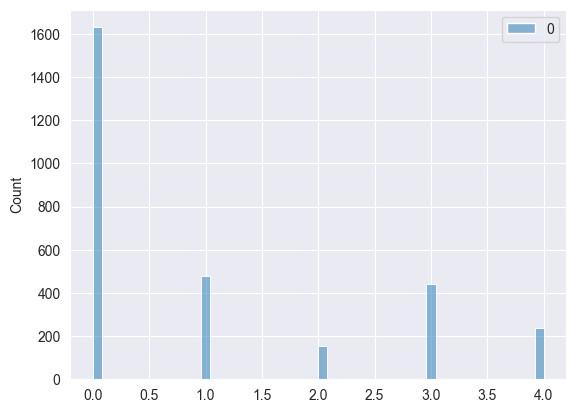

In [47]:
plt.histplot(pd.DataFrame(np.array(train_out)), bins=50)

Zbiór mocno niezbalansowany, zatem zastosujemy ważenie przykładów

In [48]:
y_np = np.array(train_out) # classes
class_weights=compute_class_weight('balanced',classes=np.unique(y_np), y=y_np)
class_weights=torch.tensor(class_weights,dtype=torch.float)

print(class_weights)

tensor([0.3606, 1.2297, 3.8169, 1.3329, 2.4907])


### Zbiór treningowy i walidacyjny

In [50]:
from torch.utils.data import DataLoader

In [51]:
BATCH_SIZE = 32
VALID_RATE = 0.15

np.random.seed(2115)
data_in_comp = torch.Tensor(train_in_padded).float()
eval_in = torch.Tensor(test_in_padded).float()
data_out_comp = torch.Tensor(train_out).long()

train_indices = np.random.rand(len(train_in_padded))>VALID_RATE
validate_indices = ~train_indices
train_set = torch.utils.data.TensorDataset(data_in_comp[train_indices], data_out_comp[train_indices])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

validate_set = torch.utils.data.TensorDataset(data_in_comp[validate_indices], data_out_comp[validate_indices])

validate_loader = DataLoader(validate_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = torch.utils.data.TensorDataset(eval_in)

In [54]:
dat_cl = next(iter(train_loader))
val_cl = next(iter(validate_loader))
print(f"{dat_cl[0].shape=} | {dat_cl[1].shape=}")
print(f"{val_cl[0].shape=} | {val_cl[1].shape=}")

dat_cl[0].shape=torch.Size([32, 6308]) | dat_cl[1].shape=torch.Size([32])
val_cl[0].shape=torch.Size([32, 6308]) | val_cl[1].shape=torch.Size([32])


### MODEL

In [55]:
SEQ_LEN = max_len
NUM_CLASSESS = len(np.unique(np.array(train_out)))
SEQ_LEN, NUM_CLASSESS

(6308, 5)

In [56]:
class CompositorClassificator(nn.Module):
    def __init__(self, input_size, hidden_size,
                 num_layers_LSTM, out_size,
                 dropout, bidirectional=False):
        super().__init__()
        self.num_layers_LSTM = num_layers_LSTM
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers_LSTM,
                            bidirectional=bidirectional, dropout=dropout)

        # self.bn_lstm = nn.BatchNorm1d(SEQ_LEN * self.bidirectional * hidden_size)
        self.fc_classificator1 = nn.Linear(in_features=SEQ_LEN * self.bidirectional * hidden_size, out_features=400)
        self.act_1 = nn.LeakyReLU()
        # self.d_1 = nn.Dropout()
        # self.fc_classificator2 = nn.Linear(in_features=500, out_features=150)
        # self.act_2 = nn.LeakyReLU()
        self.fc_out = nn.Linear(in_features=400, out_features=out_size)


    def init_hidden(self, batch_size):
        hidden_state = torch.zeros(self.num_layers_LSTM * self.bidirectional, batch_size, self.hidden_size)
        cell_state = torch.zeros(self.num_layers_LSTM * self.bidirectional, batch_size, self.hidden_size)
        return hidden_state, cell_state

    def forward(self, x, hidden):
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs, 0, 1)
        out = torch.flatten(all_outputs, 1)
        # out = self.bn_lstm(out)

        out = self.fc_classificator1(out)
        out = self.act_1(out)
        # out = self.d_1(out)
        #
        # out = self.fc_classificator2(out)
        # out = self.act_2(out)
        out = self.fc_out(out)

        return out, hidden


model = CompositorClassificator(input_size=1, hidden_size=17, num_layers_LSTM=2, out_size=NUM_CLASSESS, dropout=0.6, bidirectional=False).to(device)

### Trening

In [57]:
def count_loader_accuracy(val_model, val_loader):
    val_model.eval()
    with torch.no_grad():
        val_outs = torch.Tensor()
        val_sum_ok = 0
        n_samples = 0
        for val_x, val_targets in val_loader:
            val_x = val_x.to(device).unsqueeze(2)
            val_hidden_state, val_cell_state = val_model.init_hidden(val_x.size(0))
            val_hidden_state, val_cell_state = val_hidden_state.to(device), val_cell_state.to(device)
            val_predictions, _ = val_model(val_x, (val_hidden_state,val_cell_state))
            val_predictions = torch.argmax(val_predictions,1).cpu()
            val_outs = torch.cat([val_outs, val_predictions], dim=0)
            val_sum_ok += (val_predictions == val_targets).sum().item()
            n_samples += val_x.size(0)
    val_model.train()
    return val_sum_ok/n_samples, val_outs

In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr=4e-4, weight_decay=1e-3)
loss_fun = nn.CrossEntropyLoss(weight=class_weights.to(device))  # unballanced set
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

↓ SAVING ↓
Epoch: 0, training loss: 1.86, training accuracy: 0.111, validation accuracy: 0.117
Validation outputs class distribution:


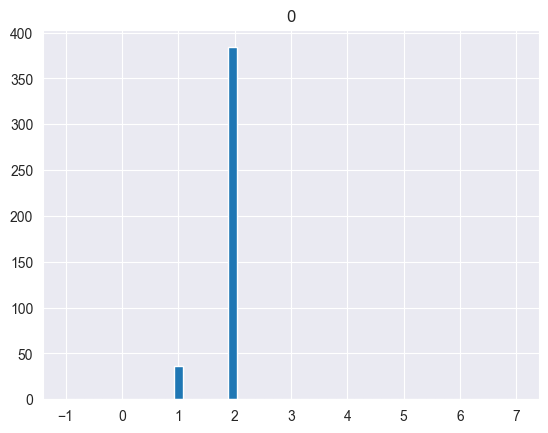

↓ SAVING ↓
Epoch: 1, training loss: 1.49, training accuracy: 0.369, validation accuracy: 0.414
Validation outputs class distribution:


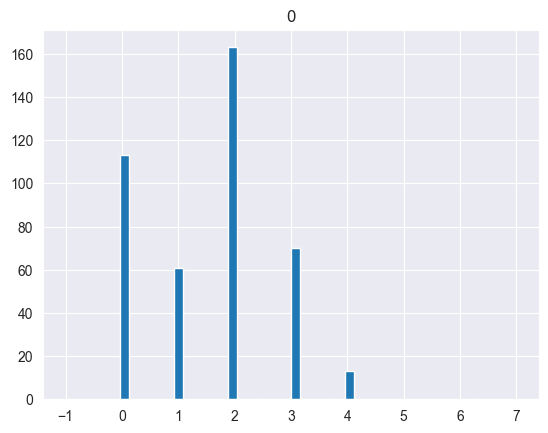

↓ SAVING ↓
Epoch: 2, training loss: 1.44, training accuracy: 0.442, validation accuracy: 0.462
Validation outputs class distribution:


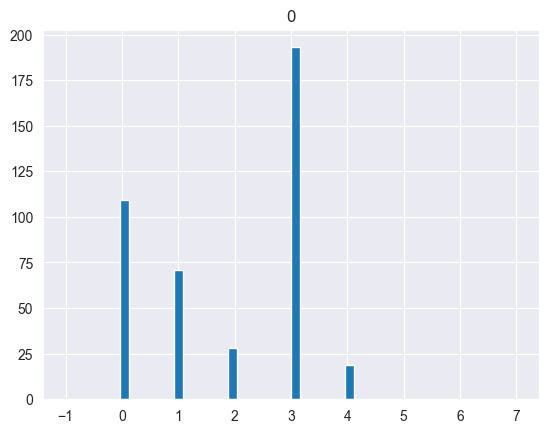

↓ SAVING ↓
Epoch: 3, training loss: 1.39, training accuracy: 0.447, validation accuracy: 0.476
Validation outputs class distribution:


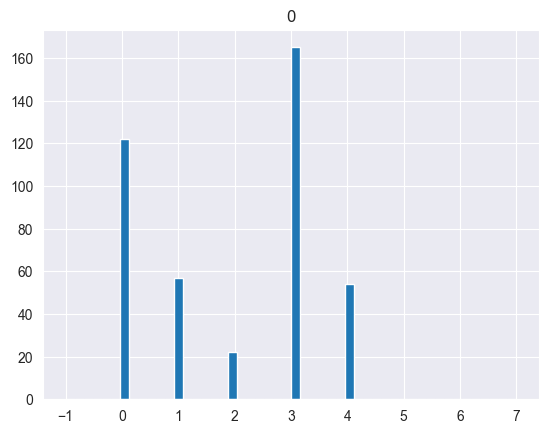

Epoch: 4, training loss: 1.35, training accuracy: 0.407, validation accuracy: 0.46
Validation outputs class distribution:


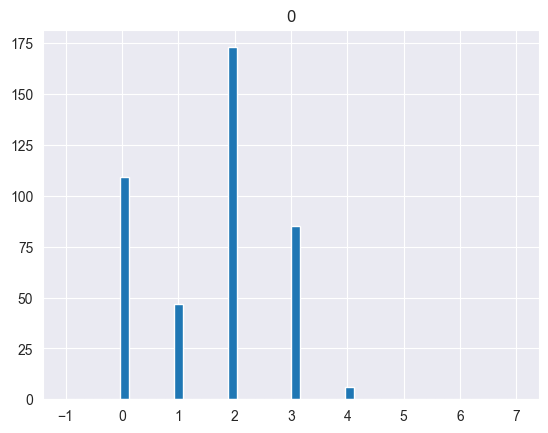

Epoch: 5, training loss: 1.3, training accuracy: 0.446, validation accuracy: 0.455
Validation outputs class distribution:


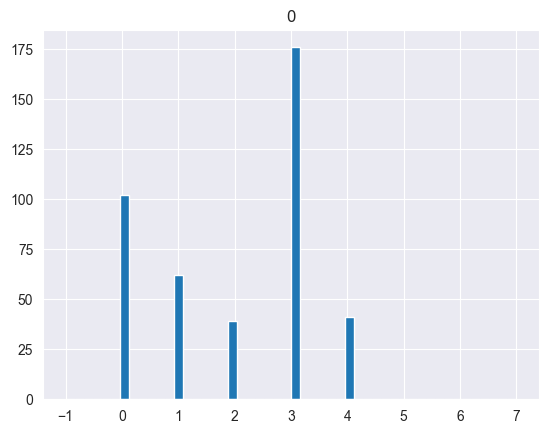

↓ SAVING ↓
Epoch: 6, training loss: 1.25, training accuracy: 0.447, validation accuracy: 0.481
Validation outputs class distribution:


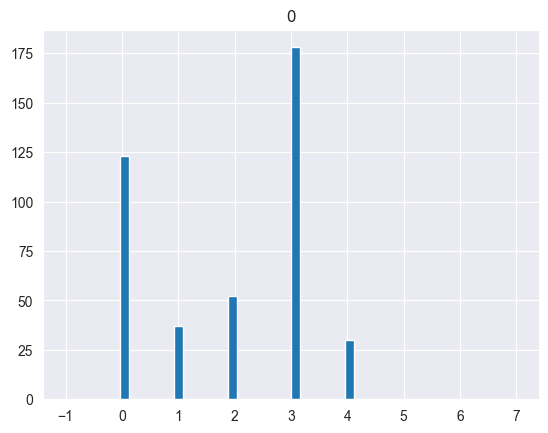

↓ SAVING ↓
Epoch: 7, training loss: 1.23, training accuracy: 0.481, validation accuracy: 0.5
Validation outputs class distribution:


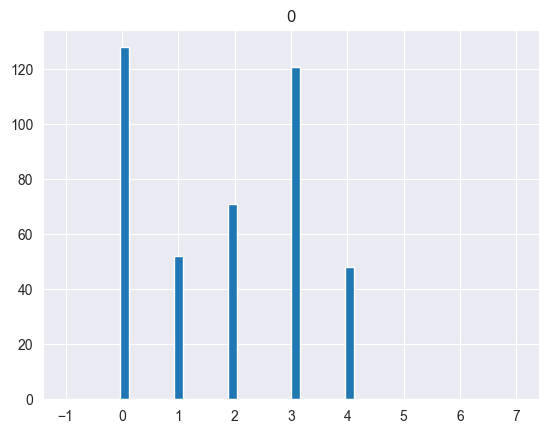

↓ SAVING ↓
Epoch: 8, training loss: 1.19, training accuracy: 0.601, validation accuracy: 0.621
Validation outputs class distribution:


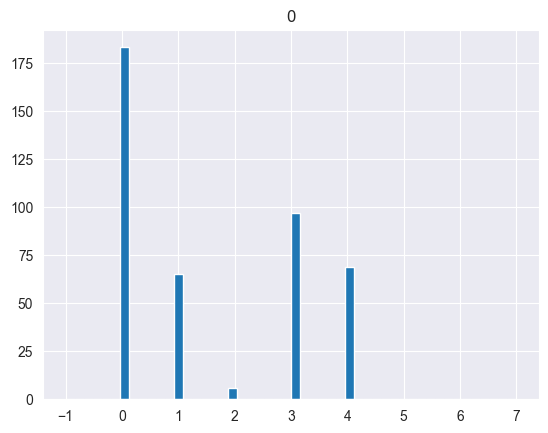

Epoch: 9, training loss: 1.15, training accuracy: 0.511, validation accuracy: 0.533
Validation outputs class distribution:


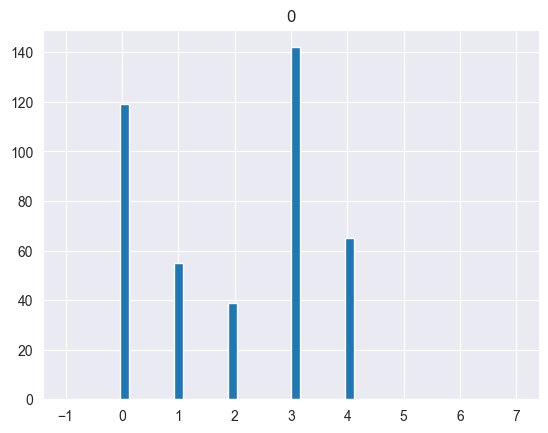

Epoch: 10, training loss: 1.12, training accuracy: 0.555, validation accuracy: 0.56
Validation outputs class distribution:


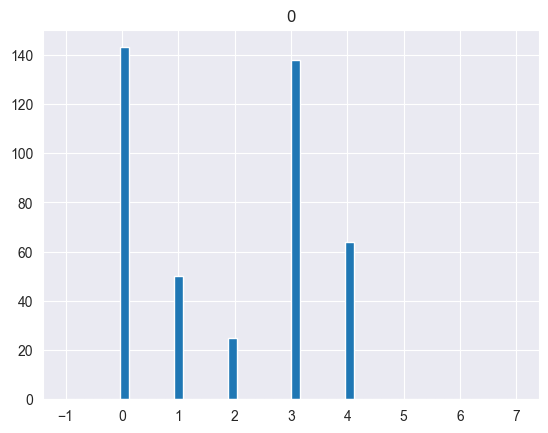

↓ SAVING ↓
Epoch: 11, training loss: 1.08, training accuracy: 0.617, validation accuracy: 0.629
Validation outputs class distribution:


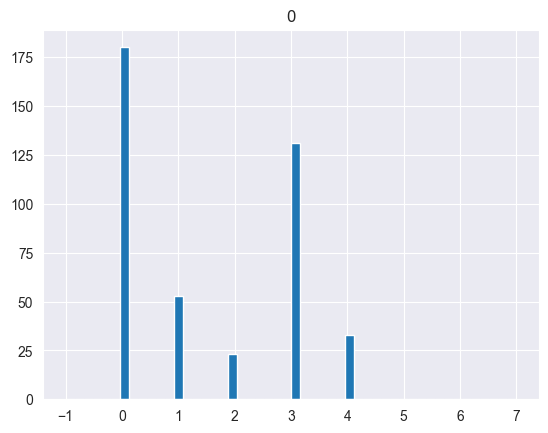

↓ SAVING ↓
Epoch: 12, training loss: 1.05, training accuracy: 0.642, validation accuracy: 0.648
Validation outputs class distribution:


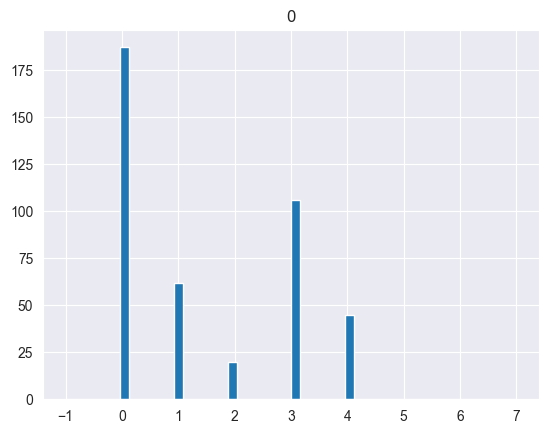

Epoch: 13, training loss: 1.04, training accuracy: 0.581, validation accuracy: 0.593
Validation outputs class distribution:


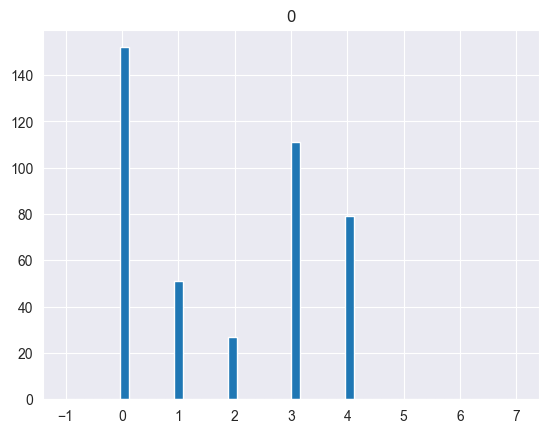

↓ SAVING ↓
Epoch: 14, training loss: 1.01, training accuracy: 0.659, validation accuracy: 0.667
Validation outputs class distribution:


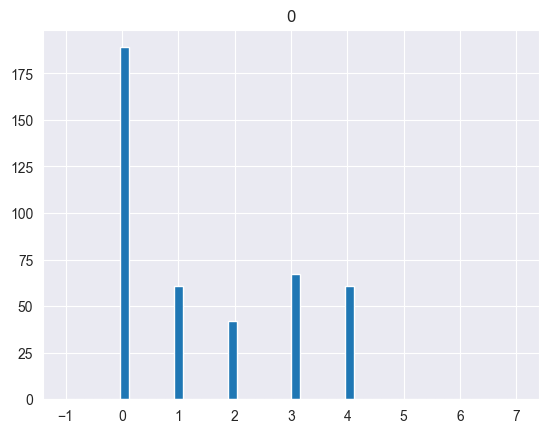

Epoch: 15, training loss: 0.998, training accuracy: 0.659, validation accuracy: 0.65
Validation outputs class distribution:


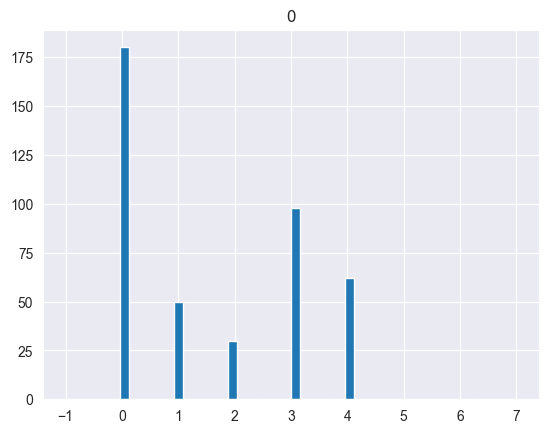

↓ SAVING ↓
Epoch: 16, training loss: 0.95, training accuracy: 0.696, validation accuracy: 0.671
Validation outputs class distribution:


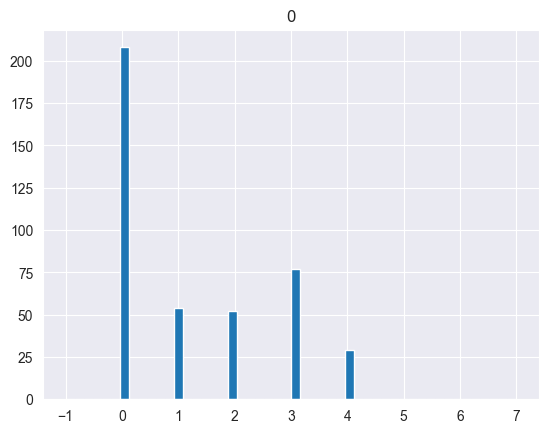

Epoch: 17, training loss: 0.928, training accuracy: 0.692, validation accuracy: 0.664
Validation outputs class distribution:


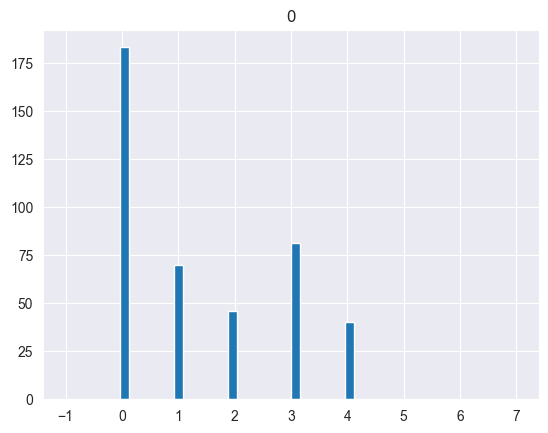

↓ SAVING ↓
Epoch: 18, training loss: 0.894, training accuracy: 0.71, validation accuracy: 0.676
Validation outputs class distribution:


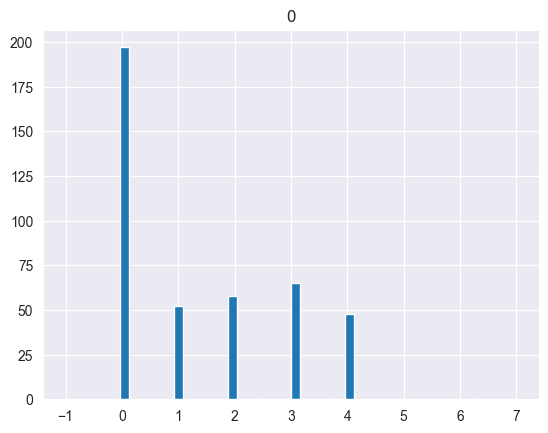

Epoch: 19, training loss: 0.877, training accuracy: 0.717, validation accuracy: 0.664
Validation outputs class distribution:


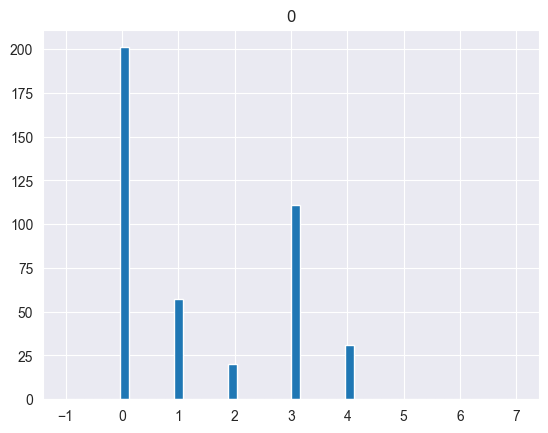

Epoch: 20, training loss: 0.843, training accuracy: 0.706, validation accuracy: 0.638
Validation outputs class distribution:


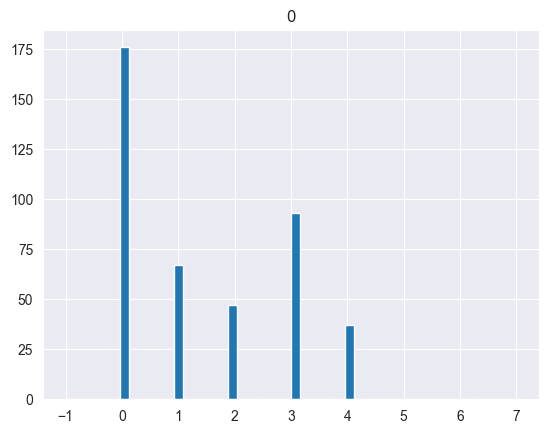

↓ SAVING ↓
Epoch: 21, training loss: 0.791, training accuracy: 0.734, validation accuracy: 0.681
Validation outputs class distribution:


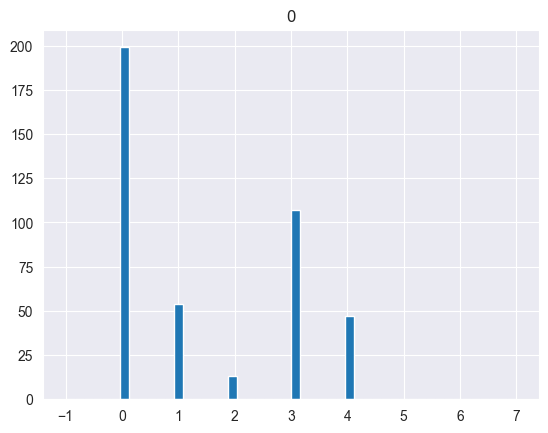

Epoch: 22, training loss: 0.754, training accuracy: 0.745, validation accuracy: 0.667
Validation outputs class distribution:


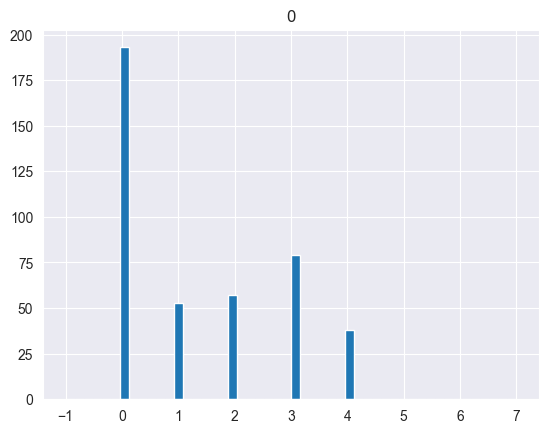

Epoch: 23, training loss: 0.72, training accuracy: 0.72, validation accuracy: 0.621
Validation outputs class distribution:


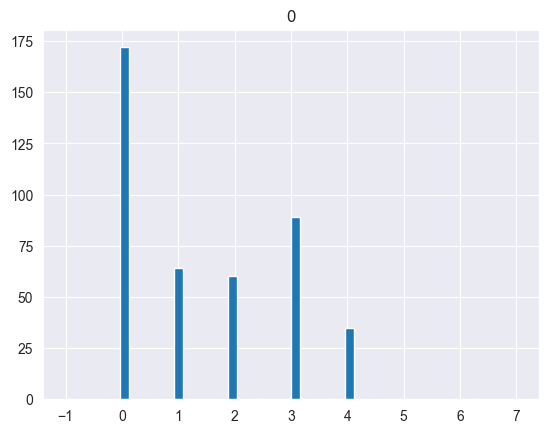

↓ SAVING ↓
Epoch: 24, training loss: 0.683, training accuracy: 0.748, validation accuracy: 0.686
Validation outputs class distribution:


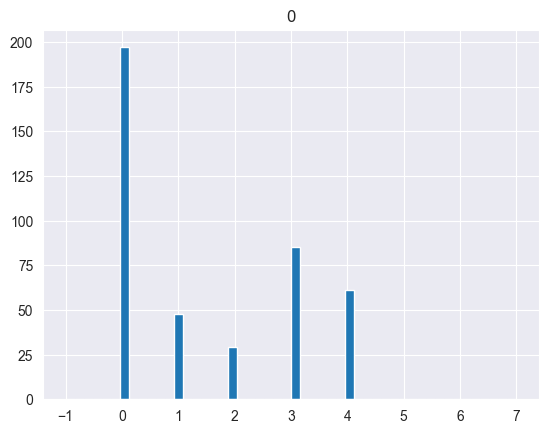

Epoch: 25, training loss: 0.651, training accuracy: 0.726, validation accuracy: 0.612
Validation outputs class distribution:


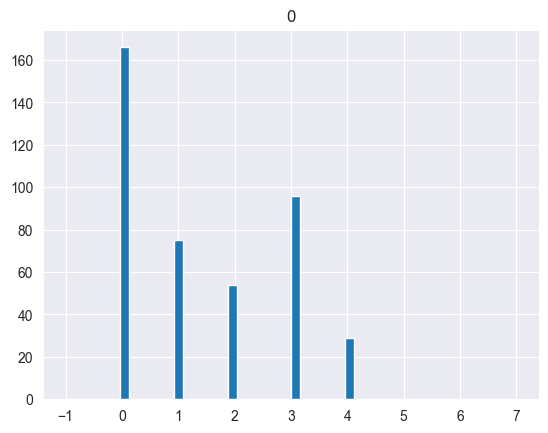

Epoch: 26, training loss: 0.616, training accuracy: 0.778, validation accuracy: 0.676
Validation outputs class distribution:


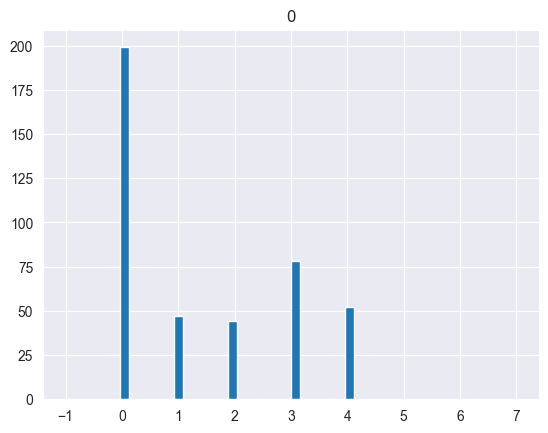

Epoch: 27, training loss: 0.581, training accuracy: 0.811, validation accuracy: 0.679
Validation outputs class distribution:


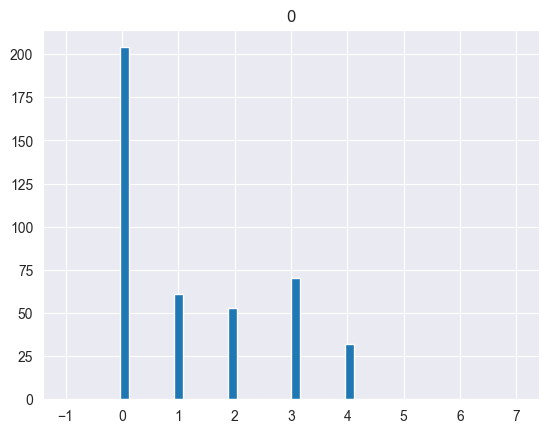

Epoch: 28, training loss: 0.556, training accuracy: 0.786, validation accuracy: 0.664
Validation outputs class distribution:


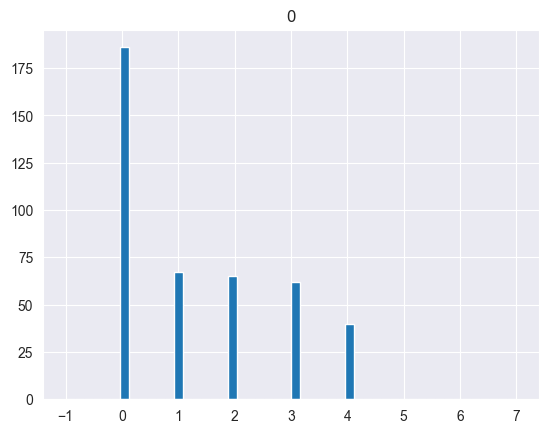

Epoch: 29, training loss: 0.521, training accuracy: 0.757, validation accuracy: 0.631
Validation outputs class distribution:


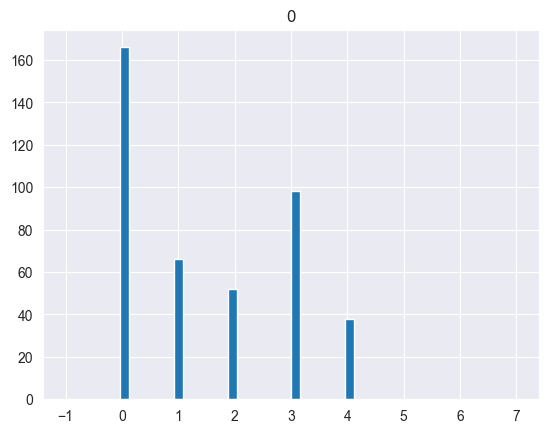

Epoch: 30, training loss: 0.49, training accuracy: 0.82, validation accuracy: 0.679
Validation outputs class distribution:


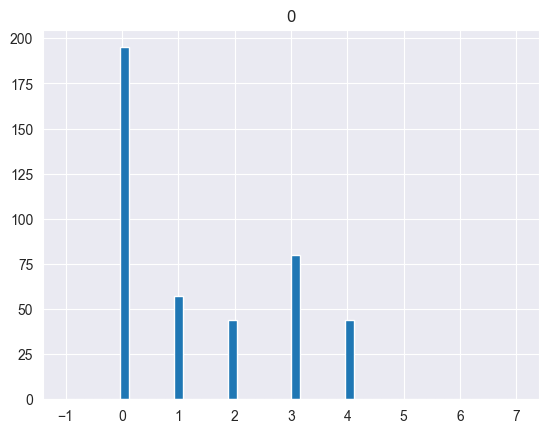

Epoch: 31, training loss: 0.456, training accuracy: 0.816, validation accuracy: 0.679
Validation outputs class distribution:


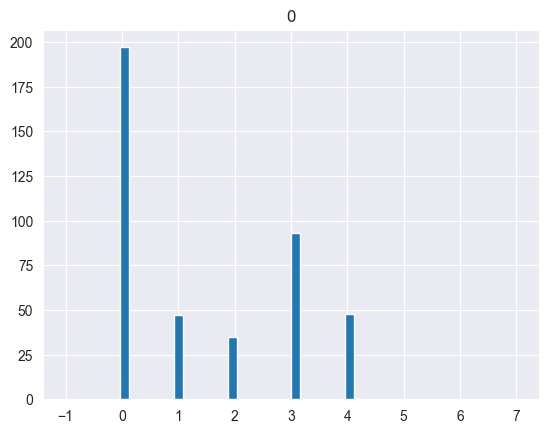

Epoch: 32, training loss: 0.416, training accuracy: 0.807, validation accuracy: 0.643
Validation outputs class distribution:


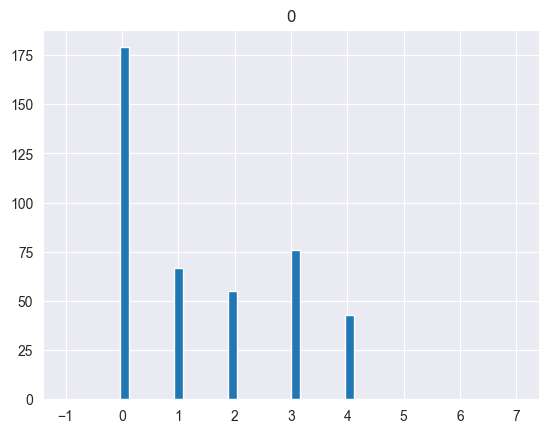

Epoch: 33, training loss: 0.402, training accuracy: 0.864, validation accuracy: 0.705
Validation outputs class distribution:


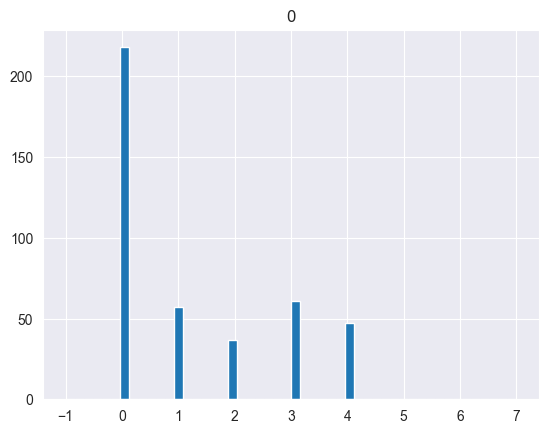

Epoch: 34, training loss: 0.355, training accuracy: 0.843, validation accuracy: 0.667
Validation outputs class distribution:


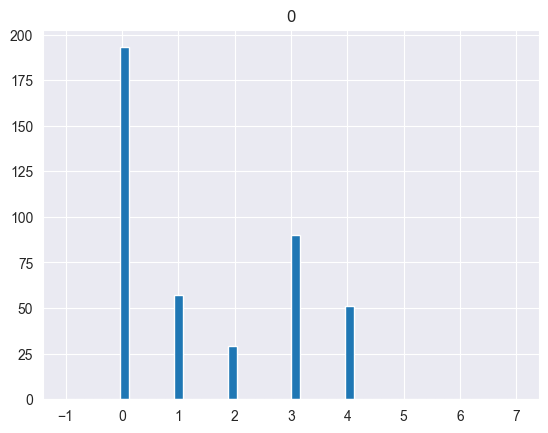

Epoch: 35, training loss: 0.349, training accuracy: 0.857, validation accuracy: 0.674
Validation outputs class distribution:


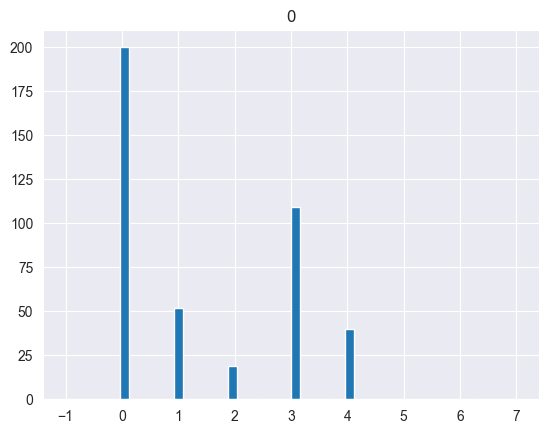

Epoch: 36, training loss: 0.322, training accuracy: 0.868, validation accuracy: 0.683
Validation outputs class distribution:


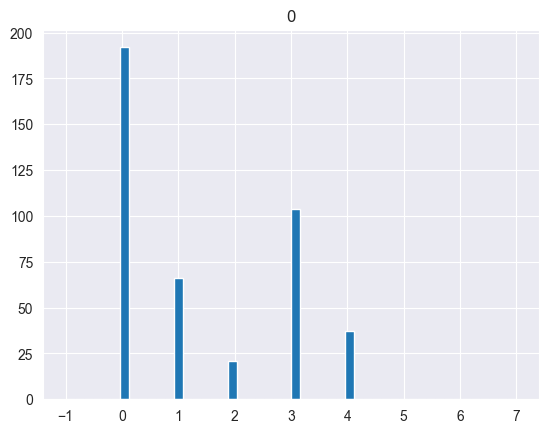

Epoch: 37, training loss: 0.286, training accuracy: 0.881, validation accuracy: 0.669
Validation outputs class distribution:


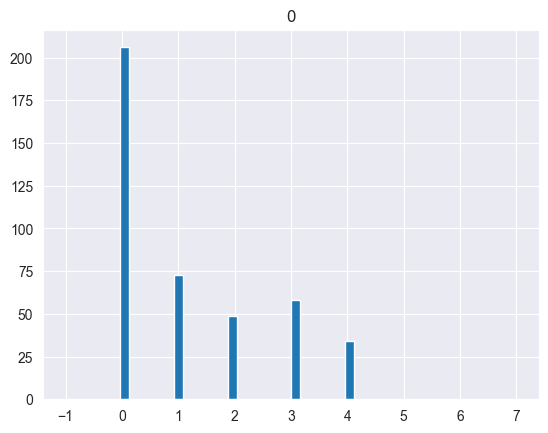

Epoch: 38, training loss: 0.282, training accuracy: 0.911, validation accuracy: 0.698
Validation outputs class distribution:


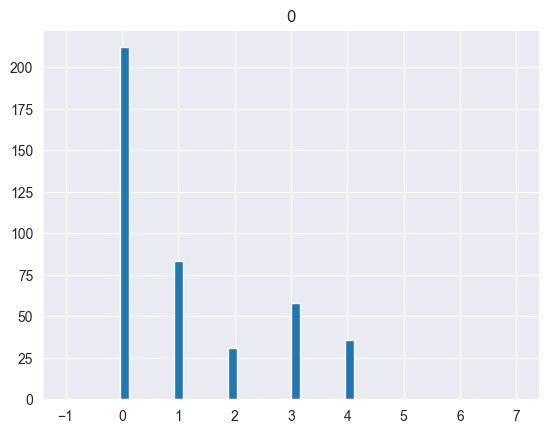

Epoch: 39, training loss: 0.264, training accuracy: 0.917, validation accuracy: 0.717
Validation outputs class distribution:


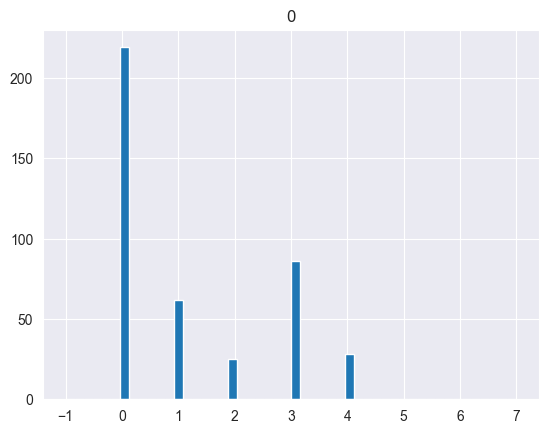

Epoch: 40, training loss: 0.237, training accuracy: 0.911, validation accuracy: 0.717
Validation outputs class distribution:


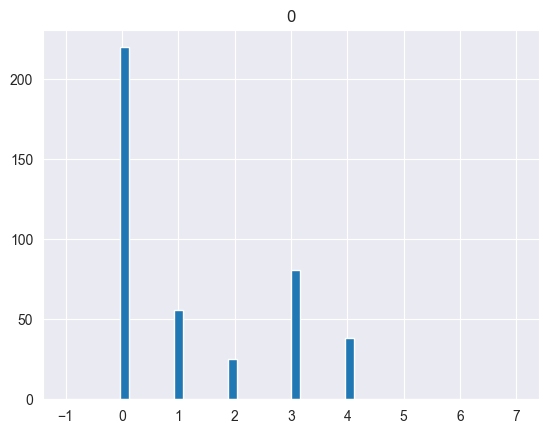

Epoch: 41, training loss: 0.219, training accuracy: 0.931, validation accuracy: 0.702
Validation outputs class distribution:


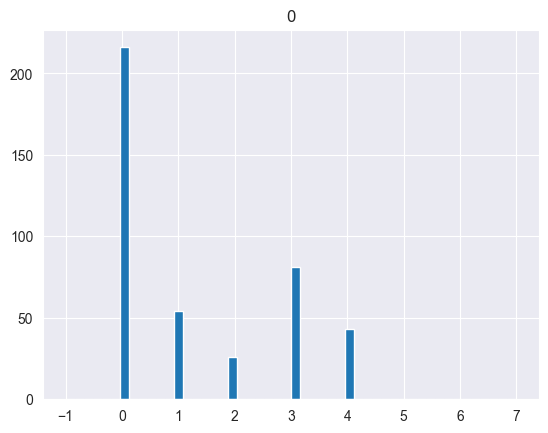

Epoch: 42, training loss: 0.198, training accuracy: 0.948, validation accuracy: 0.721
Validation outputs class distribution:


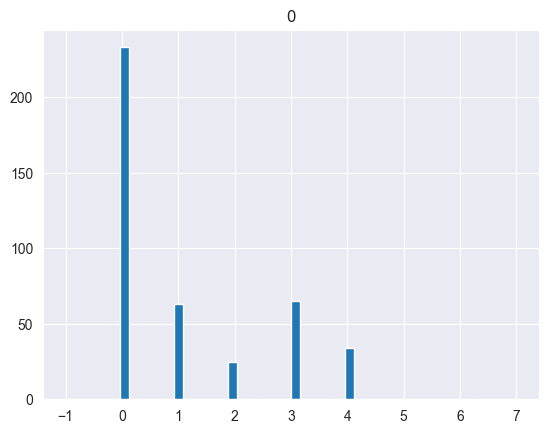

Epoch: 43, training loss: 0.204, training accuracy: 0.948, validation accuracy: 0.726
Validation outputs class distribution:


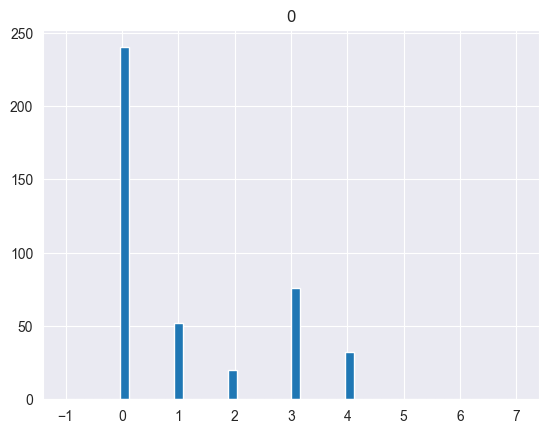

Epoch: 44, training loss: 0.174, training accuracy: 0.947, validation accuracy: 0.733
Validation outputs class distribution:


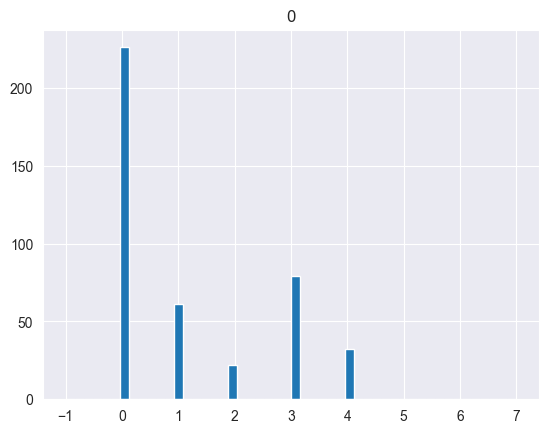

Epoch: 45, training loss: 0.167, training accuracy: 0.919, validation accuracy: 0.679
Validation outputs class distribution:


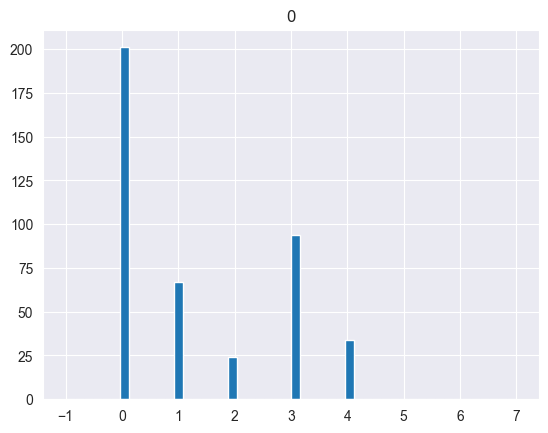

Epoch: 46, training loss: 0.165, training accuracy: 0.895, validation accuracy: 0.645
Validation outputs class distribution:


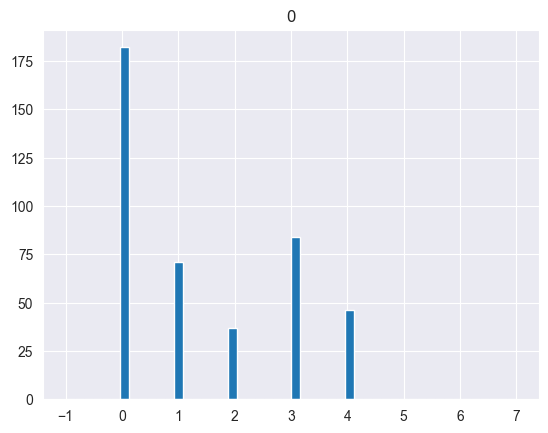

Epoch: 47, training loss: 0.162, training accuracy: 0.94, validation accuracy: 0.671
Validation outputs class distribution:


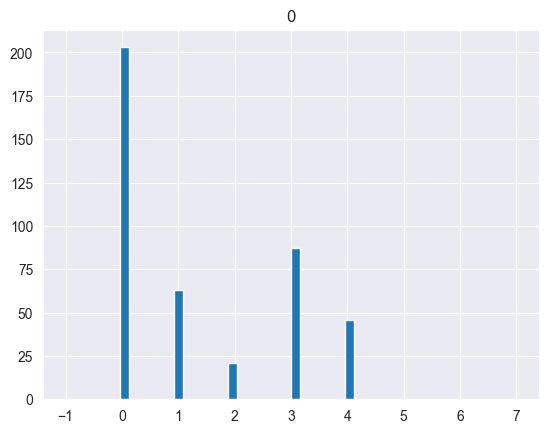

Epoch: 48, training loss: 0.141, training accuracy: 0.969, validation accuracy: 0.714
Validation outputs class distribution:


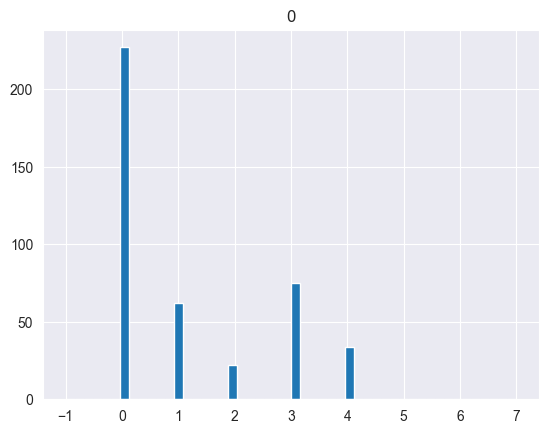

Epoch: 49, training loss: 0.142, training accuracy: 0.97, validation accuracy: 0.714
Validation outputs class distribution:


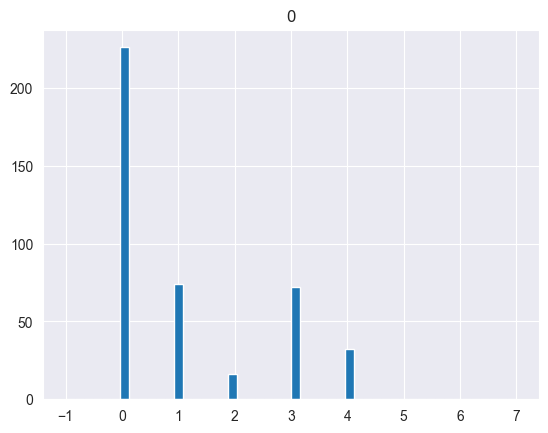

Epoch: 50, training loss: 0.139, training accuracy: 0.975, validation accuracy: 0.7
Validation outputs class distribution:


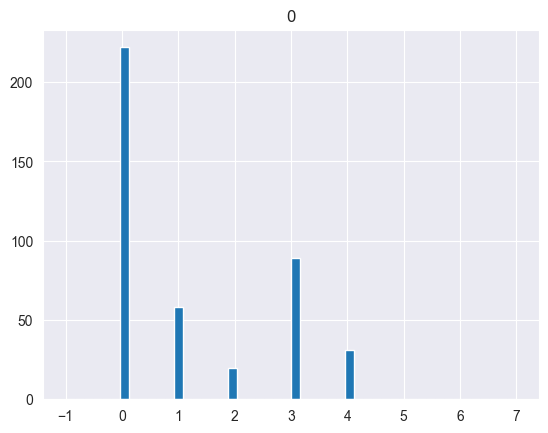

In [59]:
losses = []
val_acc = []
train_acc = []
iters = []
best_val_acc = 0
for epoch in range(51):
    epoch_lossess = []
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden_state, cell_state = model.init_hidden(x.size(0))
        hidden_state, cell_state = hidden_state.to(device), cell_state.to(device)
        preds, _ = model(x, (hidden_state, cell_state))
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        epoch_lossess.append(loss.item())
        optimizer.step()

    loss_mean = np.array(epoch_lossess).mean()

    current_train_acc, current_train_outs = count_loader_accuracy(model, train_loader)
    current_val_acc, current_val_outs = count_loader_accuracy(model, validate_loader)
    losses.append(loss_mean)
    iters.append(epoch)
    train_acc.append(current_train_acc)
    val_acc.append(current_val_acc)

    if current_val_acc > best_val_acc and current_train_acc - current_val_acc < 0.08:
        temp_state_dict = model.state_dict()
        print("↓ SAVING ↓")
        torch.save(temp_state_dict, f"model/model.tar")
        best_val_acc = current_val_acc

    # if epoch % 2 == 0:
    print(
        f"Epoch: {epoch}, training loss: {loss_mean:.3}, training accuracy: {current_train_acc:.3}, validation accuracy: {current_val_acc:.3}")
    print("Validation outputs class distribution:")
    pd.DataFrame(current_val_outs.cpu().detach().numpy()).hist(bins=50, range=(-1, 7))
    plt.show()
    scheduler.step()

## Model evalution

In [60]:
train_acc, _ = count_loader_accuracy(model, train_loader)
val_acc, _ = count_loader_accuracy(model, validate_loader)
print(f"{train_acc=}")
print(f"{val_acc=}")

train_acc=0.9745930924970226
val_acc=0.7


In [61]:
from torch.utils.data import TensorDataset

with open('data/test_no_target.pkl', 'rb') as f:
    dataset_test = pickle.load(f)
data = []
for d in dataset_test:
    data.append(torch.tensor(d))

data_padded = pad_sequence(data, batch_first=True, padding_value=0)
data_padded = torch.tensor(data_padded).float()

test_dataset = TensorDataset(data_padded, data_padded)

C:\Users\PB\AppData\Local\Temp\ipykernel_15156\1151646768.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_padded = torch.tensor(data_padded).float()


In [62]:
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [63]:
sample = next(iter(test_loader))

In [64]:
sample[0].shape

torch.Size([32, 6308])

In [65]:
outs3 = torch.Tensor()
with torch.no_grad():
    for x3 in test_loader:
        x3 = x3[0].to(device).unsqueeze(2)
        hidden_state3, cell_state3 = model.init_hidden(x3.size(0))
        hidden_state3, cell_state3 = hidden_state3.to(device), cell_state3.to(device)
        preds3, _ = model(x3, (hidden_state3,cell_state3))
        preds3 = torch.argmax(preds3.squeeze(1),1).cpu()
        # print(preds3)
        outs3 = torch.cat([outs3, preds3], dim=0).int()

array([[<Axes: title={'center': '0'}>]], dtype=object)

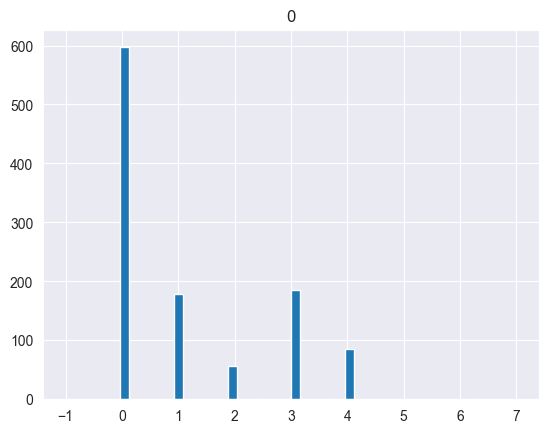

In [66]:
pd.DataFrame(outs3.cpu().detach().numpy()).hist(bins=50, range=(-1,7))

In [67]:
csv = pd.DataFrame(outs3).to_csv(index=False, header=False)
with open('results.csv', 'w', newline="") as f:
    f.write(csv)